# Thesis Figures

# Set up Notebook

In [1]:
import os
#Specify whether to use CHEESEHEAD or synthtic data 
os.environ['config'] = 'CHEESEHEAD'
# os.environ['config'] = 'synthetic'

#Import setup module
from setup import* 
from chad_funcs import *

import fsspec
import xarray as xr
import geopandas as gpd 
import geodatasets
import contextily as cx

#If using limited cases- full case list read in through setup module
cases = pd.read_csv('../Inputs/cases_limited.csv', index_col = 'case') #dataframe of tower coordinates

In [2]:
colorlist = ["#1F4E79", "#AD403D", "xkcd:grey", "#2E75B6","#CB6D6B","#BDD7EE", "#DB9B99", "xkcd:ocean blue", "xkcd:terracotta", "xkcd:magenta", "xkcd:blue green", "xkcd:grey", "xkcd:sky blue", "xkcd:light orange",
             "xkcd:grey blue", "xkcd:dark yellow", "xkcd:pale purple", "xkcd:coral",
              "xkcd:light olive", "xkcd:reddish brown", "xkcd:dark lavender", "xkcd:forrest green", 
             "xkcd:light cyan", "xkcd:orchid", "xkcd:puke yellow", "xkcd:periwinkle blue", "#CF7B67"]

## Date stuff

In [3]:
startdate = dt.datetime(2019, 6, 20)
enddate = dt.datetime(2019, 10, 13, 23, 30)
dtindex = readdata('dtindex', startdate, enddate)
hh_index = np.arange(0, 24, 0.5) #half-hourly index

In [4]:
#Dataset parameters
case = 'A' #Currently using case 1 (interp, 1000m, updown, thin_plate_spline, Benoit)
towsmin = 15 #minimum number of towers

In [5]:
towplotlist = ['PFb', 'PFe', 'PFg', 'PFh', 'PFi', 'PFj', 'PFk',
       'PFm', 'PFn', 'PFp', 'PFq', 'PFt']

## Functions

In [6]:
#Function to mean diurnal cycle
def day_cyc(dat):
    dat_day = dat.groupby(dat.index.time).mean()
    return dat_day

In [7]:
def nanfilt(x, y):
    mask = ~np.isnan(x) & ~np.isnan(y)
    x_f = x[mask]
    y_f = y[mask]
    
    return x_f, y_f

# Read in/set up data 


In [8]:
#Horizontal wind
hrz_wind = readdata('hrz_wind', startdate, enddate) #Horizontal wind- includes WS_top, WD

#MO length
MO = readdata('MO', startdate, enddate)

#zeta
zeta = readdata('zeta', startdate, enddate)

#Vertical wind
w_son = readdata('w_son', startdate, enddate)
w_cont = readdata('w_cont', startdate, enddate)

#Energy budget components
E_budget = pd.read_pickle(input_filepath + 'Cons_input_data/E_budget.pickle')

#Nans
nanmask = pd.read_pickle(intermed_filepath + 'nandat/trac_nanmask.pickle')
nancount = pd.read_pickle(intermed_filepath + 'nandat/trac_nancount.pickle')

#Met data
TA = readdata('TA', startdate, enddate)
H2O =  readdata('H2O', startdate, enddate)

In [9]:
#Read in advection data
filepath = output_filepath + 'adv_final/H_hrz_all.pickle'
H_hrz = pd.read_pickle(filepath)

filepath = output_filepath + 'adv_final/LE_hrz_all.pickle'
LE_hrz = pd.read_pickle(filepath)

filepath = output_filepath + 'adv_final/vert_ad_son.pickle'
vert_ad_son = pd.read_pickle(filepath).apply(pd.to_numeric, errors='coerce')

filepath = output_filepath + 'adv_final/vert_ad_son_abs.pickle'
vert_ad_son_abs = -pd.read_pickle(filepath).apply(pd.to_numeric, errors='coerce')

filepath = output_filepath + 'adv_final/vert_ad_cont.pickle'
vert_ad_cont = pd.read_pickle(filepath)

### Consolidate advection data

In [10]:
#Create dataframe to hold data filtered for when at least 10 towers have data
adv_nanfilt = make_multi_df([['H_hrz', 'LE_hrz', 'H_vert', 'LE_vert'], towlist], ['var', 'tow'], dtindex)

#Add each advection term  
adv_nanfilt['H_hrz'] = H_hrz[case].where(nancount.max(axis = 1)<=towsmin)
adv_nanfilt['LE_hrz'] = LE_hrz[case].where(nancount.max(axis = 1)<=towsmin)
adv_nanfilt['H_vert'] = vert_ad_son['H'].where(nancount.max(axis = 1)<=towsmin)
adv_nanfilt['LE_vert'] = vert_ad_son['LE'].where(nancount.max(axis = 1)<=towsmin)

### Energy residuals

In [11]:
#Energy residuals
E_res_na_all = E_budget.Rnet - E_budget.G - E_budget.H_turb - E_budget.LE_turb - E_budget.SH - E_budget.SLE  + E_budget.SG
#Need to figure out SG sign (seems like it is reversed from other terms)
E_res_wa = E_res_na_all - adv_nanfilt['H_hrz'] - adv_nanfilt['LE_hrz'] - adv_nanfilt['H_vert'] - adv_nanfilt['LE_vert']
E_res_na = E_res_na_all.where(E_res_wa.notnull()) #filter only for times when E_res_wa has values

In [12]:
E_res_na_perc = E_res_na/(E_budget.Rnet + E_budget.G)
E_res_wa_perc = E_res_wa/(E_budget.Rnet + E_budget.G)

### Available Energy

In [13]:
#available energy 
AE = E_budget.Rnet - E_budget.G - E_budget.SH - E_budget.SLE  #+E_budget.SG?

In [14]:
#Filter for advection > AE
# adv_nanfilt_AEfilt = 

## Bowen Ratio

In [15]:
BR_turb = E_budget.H_turb/E_budget.LE_turb
BR_adv = (adv_nanfilt.H_hrz + adv_nanfilt.H_vert)/(adv_nanfilt.LE_hrz + adv_nanfilt.LE_vert)

# Plots

In [16]:
#Select data to use
adv_use = adv_nanfilt

### 10 hz Plot

In [17]:
df_w = pd.DataFrame(index = dtindex, columns = tc.wind_var)
ts_s = pd.Series(data = dtindex.strftime('%m%d_%H'), index = dtindex)


d = 20
h = 16
startcut = dt.datetime(2019, 8, d, h)
endcut = dt.datetime(2019, 8, d, h + 3)
dtindex_cut = readdata('dtindex', startcut, endcut)
w_flat = np.empty(0)
for hour in dtindex_cut[: -1]:
    if hour.minute == 0:
        print(hour)

        url = 'http://co2.aos.wisc.edu/data/CHEESEHEAD-incoming/ISFS/high-rate/isfs_geo_hr_2019' +ts_s.loc[hour] + '.nc'
        with fsspec.open(url) as fobj:
            ds = xr.open_dataset(fobj)

        w_flat = np.append(w_flat, ds[tc.wind_var.iloc[5]].values.ravel())

2019-08-20 16:00:00
2019-08-20 17:00:00
2019-08-20 18:00:00


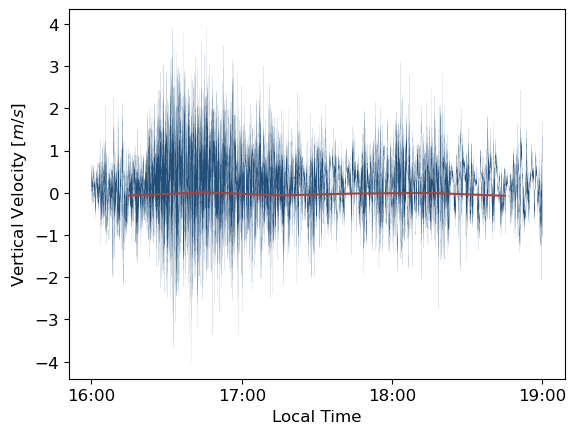

In [18]:
hr_vals = h + np.array(range(len(w_flat)))/(20*60*60)
plt.plot(hr_vals, w_flat, linewidth = 0.05, c = colorlist[0])
plt.xlabel('Local Time', fontsize = 12)
plt.ylabel('Vertical Velocity [$m/s$]', fontsize = 12)
hours = w_son['PFg'][startcut:endcut].index.hour + w_son['PFg'][startcut:endcut].index.minute/60 + 0.25
plt.plot(hours[:-1], w_son['PFg'][dtindex_cut].values[:-1], c = colorlist[1])
plt.xticks(ticks = [16, 17, 18, 19], labels = ['16:00', '17:00', '18:00', '19:00'], fontsize = 12);
plt.yticks(fontsize = 12)

plt.savefig('../../Thesis_materials/Presentation/20hz_w.png')

### Site Map

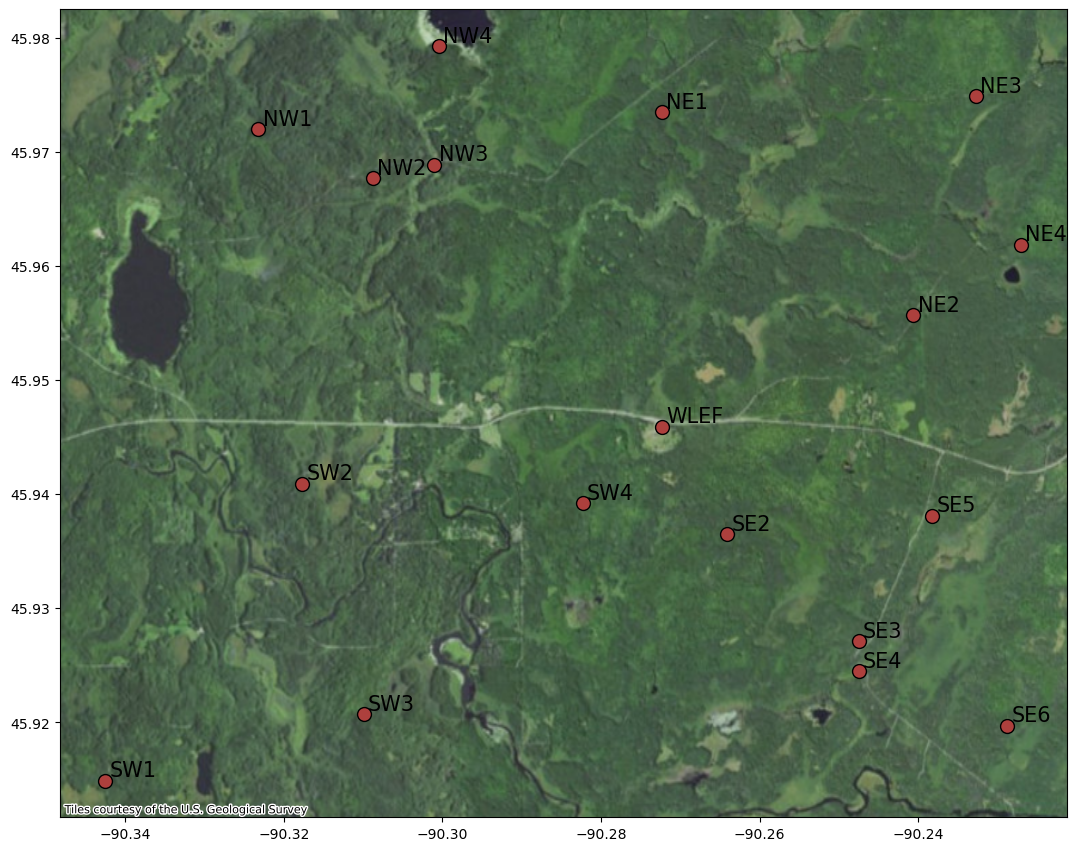

In [19]:
filepath = 'C:\\Users\\emily\\Documents\\Grad_School\\Research\\CHAS\\Analysis\\Inputs\\ameriflux-site-search.kml'
df = gpd.read_file(filepath)

df_wm = df.to_crs(epsg=3857)
df_wm = df.to_crs(epsg=4326)

CH_sites = df_wm[df_wm["Name"].str.contains("US-PF")].drop([437, 446]) #Take cheesehead sites but not PFf and PFo

ax = CH_sites.plot(figsize=(13, 13), color=colorlist[1], edgecolor = 'k', markersize= 100)
cx.add_basemap(ax, source=cx.providers.USGS.USImagery, crs='EPSG:4326')


for x, y, label in zip(CH_sites.geometry.x, CH_sites.geometry.y, tc.dir_names):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize =15, c = 'k')
    
x_c, y_c = CH_sites.loc[432].geometry.x, CH_sites.loc[432].geometry.y

plt.savefig('../../Thesis_materials/Presentation/site_map.png')

# # Customize the x-axis ticks: Convert to km and adjust relative to x_c
# ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{(x - x_c)/1000:.0f}'))

# # Customize the y-axis ticks: Convert to km and adjust relative to y_c
# ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{(y - y_c)/1000:.0f}'))


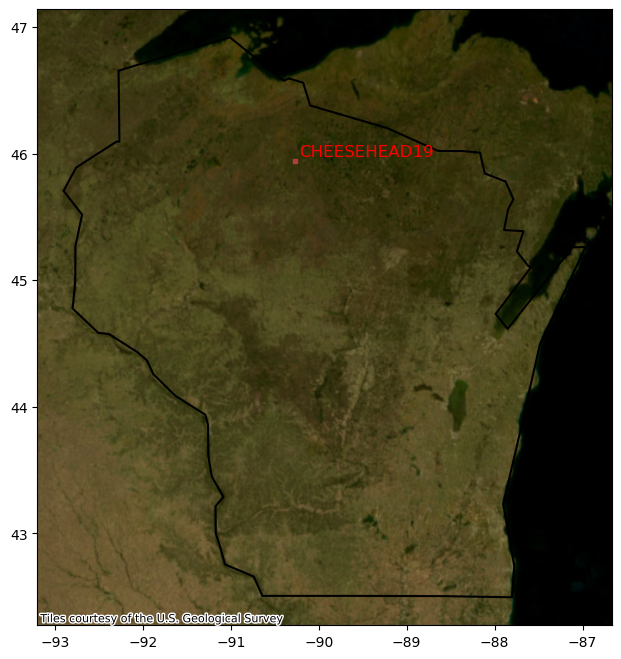

In [20]:
# Select only the first tower (or a specific one)
first_tower = CH_sites.iloc[[0]]  # Selects first row (first tower)

# Download or load a shapefile for Wisconsin (you can download one from a public source)
# Here I assume you have a shapefile of US states and filter for Wisconsin
filepath = ('../../Thesis_materials/state_shapes/ne_110m_admin_1_states_provinces_lakes.shp')
us_states = gpd.read_file(filepath)



# Filter for Wisconsin
wisconsin = us_states[us_states['name'] == 'Wisconsin']

# Load CHEESEHEAD site data
filepath = 'C:/Users/emily/Documents/Grad_School/Research/CHAS/Analysis/Inputs/ameriflux-site-search.kml'
df = gpd.read_file(filepath)

df_wm = df.to_crs(epsg=4326)

# Filter the first tower in CH_sites
CH_sites = df_wm[df_wm["Name"].str.contains("US-PF")].drop([437, 446])
first_tower = CH_sites.iloc[[0]]  # Select the first tower

# Plot Wisconsin and the first tower location
fig, ax = plt.subplots(figsize=(8, 8))
wisconsin.boundary.plot(ax=ax, color='k')
first_tower.plot(ax=ax, color=colorlist[1], markersize=5, marker = 's')

# Annotate tower name
x, y = first_tower.geometry.x.values[0], first_tower.geometry.y.values[0]
ax.annotate('CHEESEHEAD19', xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=12, color='red')
cx.add_basemap(ax, source=cx.providers.USGS.USImagery, crs='EPSG:4326')

plt.show()

## Interp Methods Plots

In [21]:
# startdate_cut = dt.datetime(2019, 7, 18)
# enddate_cut = dt.datetime(2019, 7, 19)
# plt.plot(WD.isna().sum(axis = 1)[startdate_cut:enddate_cut])
# plt.xticks(rotation = 45);

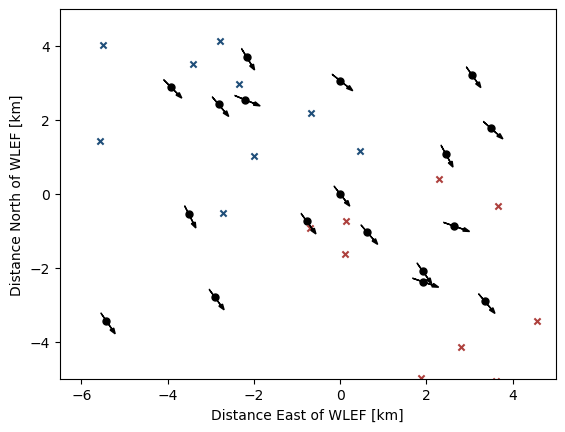

In [22]:
#Horizontal Interpolation method
WD = hrz_wind['WD']
plotdate = dt.datetime(2019, 7, 20, 18)
# plotdate = dt.datetime(2019, 7, 20, 12)

#Get coordinates for interpolation points and ends of arrow
interpcoords = updowncoords(5000, WD, tc).loc[plotdate]
windarrowcoords = updowncoords(250, WD, tc).loc[plotdate] #change first parameter to change length of arrow

#Set fig dimensions
# plt.figure(figsize = (6, 6))
# plt.xlim(-6, 5);
# plt.ylim(-6, 5);
    

#Plot towers as black points
plt.scatter(tc.x/1000, tc.y/1000, c = 'k', s = 25, marker = 'o')

#Plot up and downwind 
plt.scatter(interpcoords.loc[: ,'up', 'x']/1000, interpcoords.loc[: ,'up', 'y']/1000, c = colorlist[0], marker = 'x', s = 20)
plt.scatter(interpcoords.loc[: ,'down', 'x']/1000, interpcoords.loc[: ,'down', 'y']/1000, c = colorlist[1], marker = 'x', s = 20)

# Plot wind arrows
for tow in towlist:
    plt.arrow(windarrowcoords.loc[tow ,'up', 'x']/1000, windarrowcoords.loc[tow ,'up', 'y']/1000, 
              windarrowcoords.loc[tow ,'down', 'x']/1000 - windarrowcoords.loc[tow ,'up', 'x']/1000, 
              windarrowcoords.loc[tow ,'down', 'y']/1000 - windarrowcoords.loc[tow ,'up', 'y']/1000,
             head_width = .1, facecolor = 'k')
    
plt.xlabel('Distance East of WLEF [km]');
plt.ylabel('Distance North of WLEF [km]');

plt.xlim(-6.5, 5)
plt.ylim(-5, 5)


plt.savefig('../../Thesis_materials/Presentation/hrz_interp_methods_map_5000.png')

In [23]:
for case in ['A']:
    print(case)
    grad_method = cases['grad_method'].loc[case]
    interpdist = cases['interp_dist'].loc[case]
    interpdir = cases['interp_dir'].loc[case]
    stab_meth = cases['stability'].loc[case]
    kernel = cases['interp_kernel'].loc[case]

    if grad_method == 'gradavg':
        filepath = intermed_filepath + 'hrz_gradients/'+ grad_method + '.pickle'
        
    elif grad_method == 'interp':
        filepath = intermed_filepath + 'hrz_gradients/tracer' + grad_method + str(interpdist) + interpdir + kernel + '.pickle'
    
    # # Filepath for shortened time
    filepath = intermed_filepath + 'hrz_gradients/tracer' + grad_method + str(interpdist) + str(interpdir) \
     + str(kernel) +str(stab_meth) + startdate.strftime("%m%d")+ '-'+ enddate.strftime("%m%d")+'.pickle'
    
    with open(filepath, 'rb') as handle:
        hrz_grad = pickle.load(handle)

A


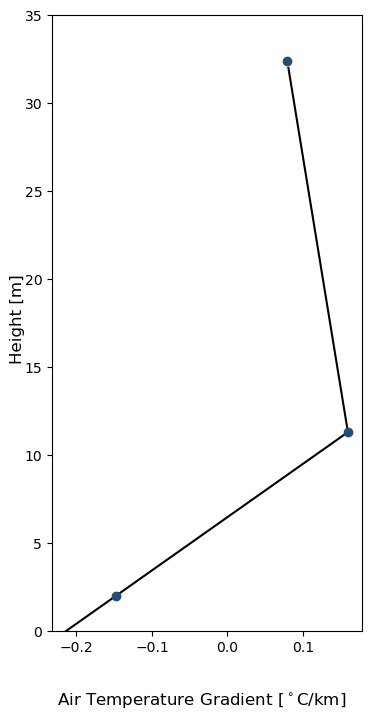

In [24]:
tow = 'PFn'
plotdate = dt.datetime(2019, 8, 20, 18)
plot_points = hrz_grad.loc[plotdate, ('TA', slice(None), tow)]
zs = get_zs('mes', tow)

fig, ax = plt.subplots(1, figsize = [4, 8], sharey=True)
plt.ylim(0, 35);
fig.supylabel('Height [m]')
fig.supxlabel('Air Temperature Gradient [$^\circ$C/km]')
plotdate = dt.datetime(2019, 8, 20, 18)

#Plot regular 
dat = hrz_grad['TA']

T_prof = prof_calcs(tow, dat, 'mes', dtindex, step = 0.1)
ax.plot(T_prof.loc[plotdate]*1000, T_prof.loc[plotdate].index, c= 'k')
ax.scatter(dat.loc[plotdate][:, tow]*1000, zs, c = colorlist[0], zorder = 2)


plt.savefig('../../Thesis_materials/Presentation/vert_prof_interp_methods_grad.png')

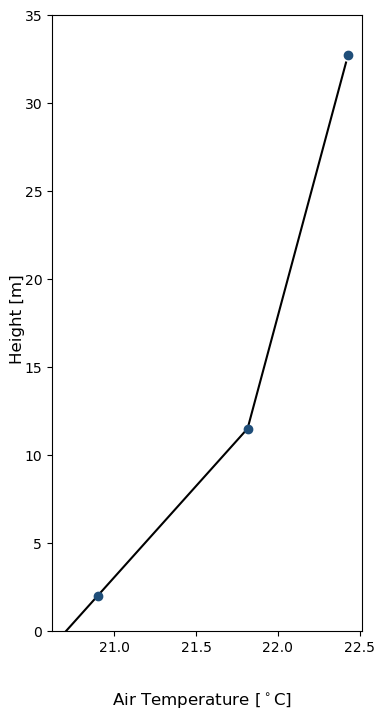

In [25]:
fig, ax = plt.subplots(1, figsize = [4, 8], sharey=True)
plt.ylim(0, 35);
fig.supylabel('Height [m]')
fig.supxlabel('Air Temperature [$^\circ$C]')
plotdate = dt.datetime(2019, 8, 20, 18)

#Plot regular 
tow = 'PFe'
dat = TA

T_prof = prof_calcs(tow, dat, 'mes', dtindex, step = 0.1)
ax.plot(T_prof.loc[plotdate], T_prof.loc[plotdate].index, c= 'k')
ax.scatter(dat.loc[plotdate][:, tow], get_zs('mes', tow), c = colorlist[0], zorder = 2)



plt.savefig('../../Thesis_materials/Presentation/vert_prof_interp_methods.png')

## Magnitude of and Relationships Between Advective Flux Components

In [26]:
adv_comps = ['H_hrz', 'LE_hrz', 'H_vert', 'LE_vert']
for comp in adv_comps:
    print(comp, adv_use[comp].stack().mean(), ', ', adv_use[comp].stack().std() )

H_hrz 0.18039233258223145 ,  5.439688252141214
LE_hrz 0.9341931558992264 ,  9.714836771279007
H_vert -1.8599182044688916 ,  74.95833517785424
LE_vert -4.136834418451352 ,  114.90119281968794


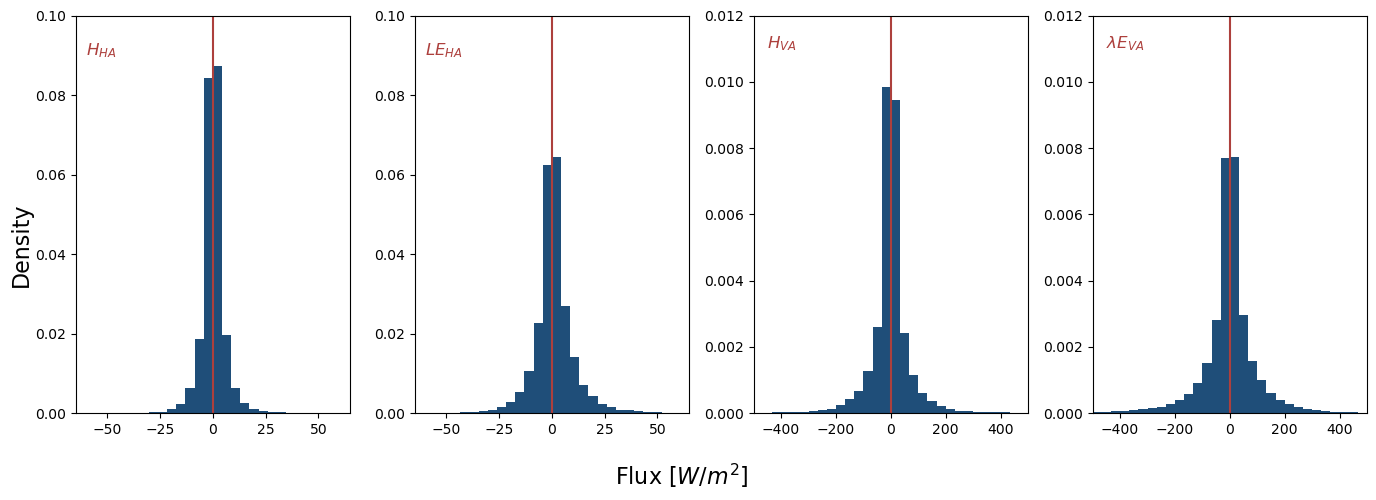

In [27]:
tow = 'PFg'
fig, axs = plt.subplots(1, 4, figsize = (14, 5))
comp_lab_list = ['$H_{HA}$', '$\lambdaE _{HA}$', '$H_{VA}$', '$\lambda E_{VA}$']
xlims = [[-65, 65], [-65, 65], [-500, 500], [-500, 500]]
ylims = [[0, 0.1], [0, 0.1], [0, 0.012], [0, 0.012]]
label_loc = [[-60, 0.09], [-60, 0.09], [-450, 0.011], [-450, 0.011]]



for i in range(4):
    comp = adv_comps[i]
    # ax = axs[i//2, i%2]
    ax = axs[i]
    adv_flat = adv_use[comp].stack().values
    ax.hist(adv_flat[np.isfinite(adv_flat)], bins = 30, color = colorlist[0], range = xlims[i], density = True)
    ax.annotate(comp_lab_list[i], label_loc[i], size = 12,  c =colorlist[1])
    ax.set_xlim(xlims[i][0], xlims[i][1])
    ax.set_ylim(ylims[i][0], ylims[i][1])
    ax.vlines(0, ylims[i][0], ylims[i][1], color = colorlist[1])
    
fig.supxlabel('Flux [$W/m^2$]', fontsize = 16)
fig.supylabel('Density', fontsize = 16)
plt.tight_layout()
plt.savefig('../../Thesis_materials/Presentation/comp_hist_with_vert_line.png')

In [28]:
# x_11 = np.arange(-35, 40, 70)

# fig, ax = plt.subplots(1, 2, figsize = [8, 6], sharex = True, sharey = True)

# #Horizontal Fluxes
# x, y = nanfilt(adv_nanfilt.H_hrz.to_numpy().flatten(), adv_nanfilt.H_vert.to_numpy().flatten())
# regress = scipy.stats.linregress(x, y)
# ax[0].scatter(x, y, marker = '.', edgecolors=colorlist[0], alpha = 0.05);
# ax[0].plot(x_11, regress[0]*x_11 + regress[1], c = colorlist[1])
# ax[0].annotate('H', (30, 250), size = 15, c = colorlist[1])
# print('H R2: ', regress[2]**2, regress[0])

# #Vertical Fluxes
# x, y = nanfilt(adv_nanfilt.LE_hrz.to_numpy().flatten(), adv_nanfilt.LE_vert.to_numpy().flatten())
# regress = scipy.stats.linregress(x, y)
# ax[1].scatter(x, y, marker = '.', edgecolors=colorlist[0], alpha = 0.05);
# ax[1].plot(x_11, regress[0]*x_11 + regress[1], c = colorlist[1])
# ax[1].annotate('LE', (30, 250), size = 15, c = colorlist[1])


# plt.xlim(-40, 40)
# plt.ylim(-300, 300)


# fig.supxlabel('Horizontal H Flux [$W/m^2$]')
# fig.supylabel('Vertical Flux [$W/m^2$]')

# plt.savefig('../../Thesis_materials/hrx_v_vert_adv.png')
# print('LE R2: ', regress[2]**2, regress[0])

(0.0875779194018077, 0.014620251374089786)

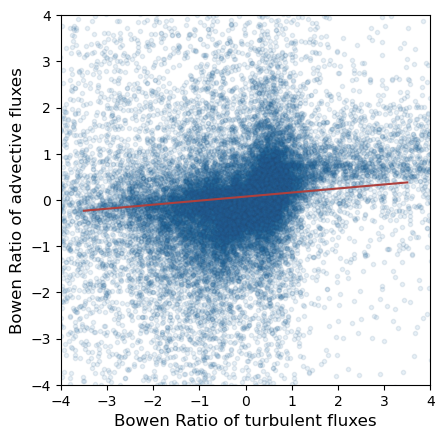

In [29]:
lim = 10 #Lim for Br used in regression
plt_lim = 4 #Lim for plotting
x, y = nanfilt(BR_turb.where((BR_turb<lim) &(BR_turb >-lim)).to_numpy().flatten(), BR_adv.where((BR_adv<lim) &(BR_adv >-lim)).to_numpy().flatten())
# x, y = nanfilt(BR_turb.where((BR_turb<5) &(BR_turb >-5))[tow].to_numpy().flatten(), BR_adv.where((BR_adv<5) &(BR_adv >-5))[tow].to_numpy().flatten())
# plt.hist2d(x, y, range = [[-plt_lim, plt_lim], [-plt_lim, plt_lim]], bins = 50, cmap = 'Blues');


# plt.scatter(x, y, marker = 'o', facecolors='none', edgecolors=colorlist[0], alpha = 0.1);
plt.scatter(x, y, marker = '.', edgecolors=colorlist[0], alpha = 0.1);
plt.axis('scaled')

plt.xlim(-plt_lim, plt_lim)
plt.ylim(-plt_lim, plt_lim)
regress = scipy.stats.linregress(x, y)

x_11 = np.arange(0.5-plt_lim, 3*plt_lim-1.5, 2*plt_lim-1)
# plt.plot(x_11, x_11, c = 'k')
plt.plot(x_11, regress[0]*x_11 + regress[1], c = colorlist[1])
plt.xlabel('Bowen Ratio of turbulent fluxes', fontsize = 12)
plt.ylabel('Bowen Ratio of advective fluxes', fontsize = 12)


plt.savefig('../../Thesis_materials/Presentation/BR_turb_adv_regressline.png')

regress[0], regress[2]**2

## Contribution of Advective Fluxes to Energy Balance

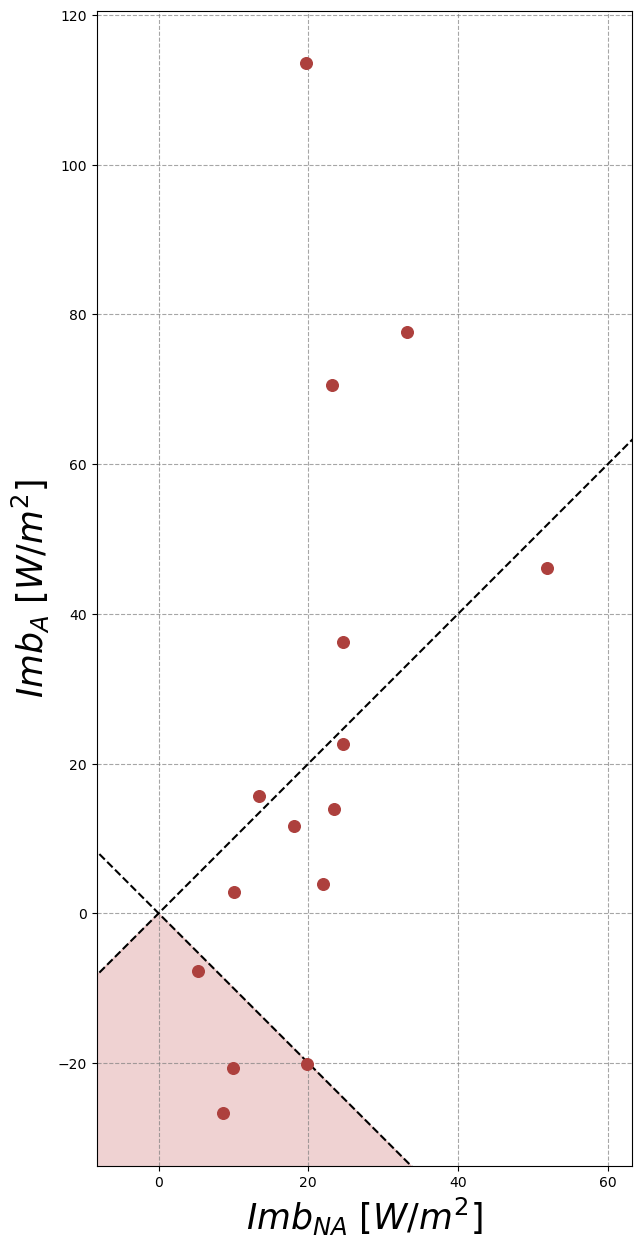

In [30]:
#Scatter plot showing imbalance before and after adcvction included

plt.figure(figsize = (8, 15))

#scatter plot of Imb without advection v. Imb with advection 
for tow in towlist:
    plt.scatter(E_res_na[tow].mean(), E_res_wa[tow].mean(), c = colorlist[1], zorder = 3, s = 70)
    
    # #Lable towers, need to flip side of some labels to not overlap with lines
    # if tc.loc[tow].dir_names == 'SE5' or tc.loc[tow].dir_names == 'SE3':
    #     plt.annotate(tc.loc[tow].dir_names, (E_res_na[tow].mean() - 4, E_res_wa[tow].mean() + 0.5), zorder = 3)
    # else:
    #     plt.annotate(tc.loc[tow].dir_names, (E_res_na[tow].mean() + 0.5, E_res_wa[tow].mean() + 0.5), zorder = 3) 

#A couple points to just make the plot a little wider
plt.scatter(60, 50, c = 'w')
plt.scatter(-5, 50, c = 'w')


plt.xlim(-10, 70)
plt.ylim(-30, 120)

plt.axis('scaled') #Makes scale of x and y same

#plot +/- 1-1 line
x_11 = np.arange(-10, 70, 5) #values for a one-to-one line
plt.plot(x_11, x_11, c = 'k', zorder = 2, linestyle = '--')
plt.plot(x_11, -x_11, c = 'k', zorder = 2, linestyle = '--')

# #For horizontal only - +/- 10% lines
# plt.plot(x_11, x_11*1.1, c = colorlist[2], zorder = 2, linestyle = '--')
# plt.plot(x_11, x_11*0.9, c = colorlist[2], zorder = 2, linestyle = '--')

#Fill in area where Imb improves
# plt.fill_between(np.arange(0, 90, 5), -np.arange(0, 90, 5), np.arange(0, 90, 5), color=colorlist[5], alpha=0.3, label='Improved Energy Balance', zorder = 1)
plt.fill_between(np.arange(-10, 90, 5), -np.abs(np.arange(-10, 90, 5)), -np.arange(140, 240, 5), color=colorlist[4], alpha=0.3, label='Improved Energy Balance', zorder = 1)

#Add grid and make xticks same as y 
plt.grid(True, which='both', linestyle='--', color='gray', alpha=0.7)
plt.xticks([0, 20, 40, 60]);
# plt.xlim(0, 60)
# plt.ylim(0, 60)

#Axes labels
plt.xlabel('$Imb_{NA}$ [$W/m^2$]', fontsize = 25)
plt.ylabel('$Imb_{A}$ [$W/m^2$]',  fontsize = 25)
plt.savefig('../../Thesis_materials/Presentation/Imb_change_lowershade.png')

In [31]:
# pos_impr_count.sum()/all_impr_count.sum()

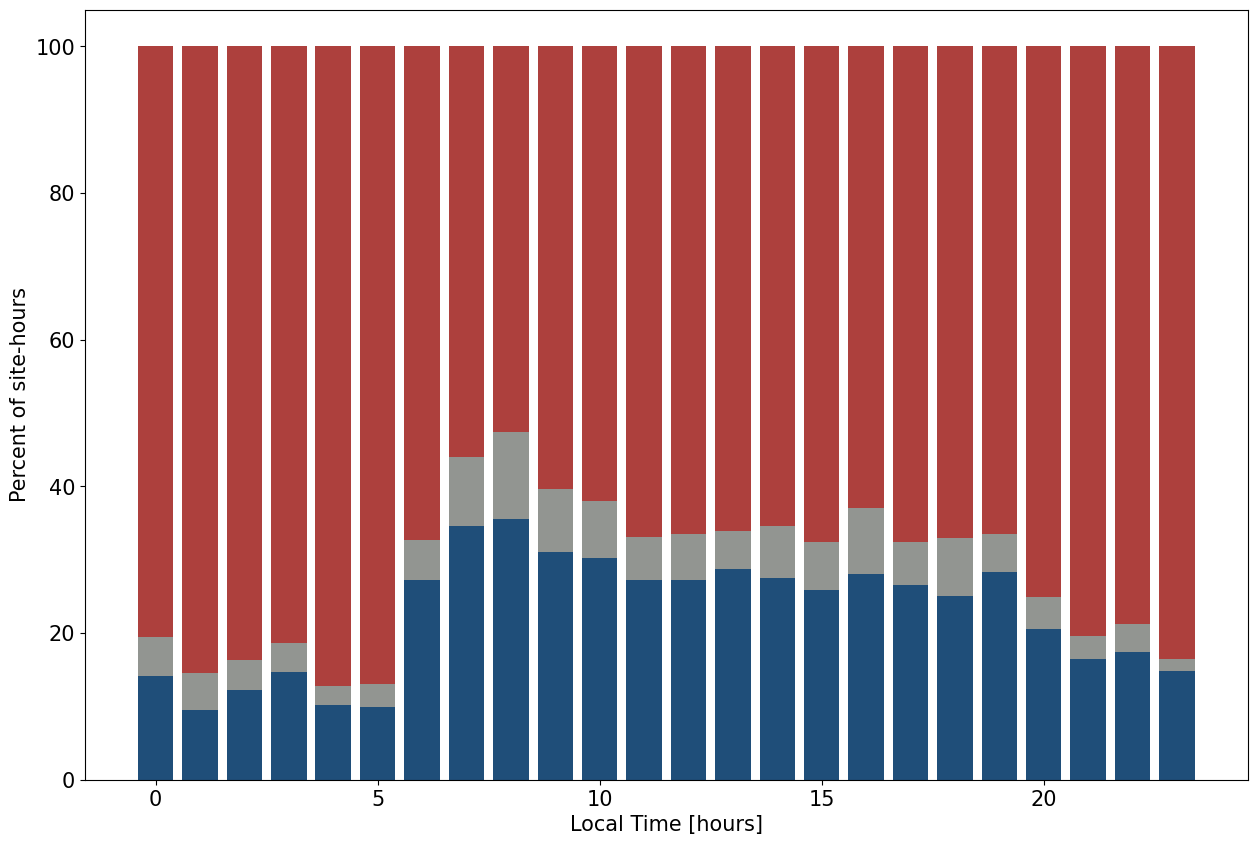

In [32]:
#Calculate Percent of Times Improved
cutoff_perc = 0.1

E_res_na_hr = E_res_na.resample('1h').mean()
E_res_wa_hr = E_res_wa.resample('1h').mean()

E_res_na_pos = E_res_na_hr.where(E_res_na_hr>=0) #Only when residual is positive

E_res_impr = (E_res_na_pos.abs() - E_res_wa.abs())/E_res_na_pos.abs()

pos_impr = E_res_impr>cutoff_perc
neg_impr = E_res_impr<-cutoff_perc
no_impr = (E_res_impr<=cutoff_perc)&(E_res_impr>=-cutoff_perc)

pos_impr_count = pos_impr.groupby(pos_impr.index.hour).sum().sum(axis = 1)
neg_impr_count = neg_impr.groupby(neg_impr.index.hour).sum().sum(axis = 1)
no_impr_count = no_impr.groupby(no_impr.index.hour).sum().sum(axis = 1)

all_impr_count = pos_impr_count + neg_impr_count + no_impr_count

pos_impr_perc = pos_impr_count/all_impr_count*100
neg_impr_perc = neg_impr_count/all_impr_count*100
no_impr_perc = no_impr_count/all_impr_count*100

#Plot bar chart of improved times

plt.figure(figsize=(15, 10))
plt.bar(pos_impr_perc.index, pos_impr_perc + no_impr_perc + neg_impr_perc, color = colorlist[1], 
        label = 'Energy residual increased with advection')
plt.bar(pos_impr_perc.index, pos_impr_perc + no_impr_perc, color = colorlist[2], label = 'No significant change')
plt.bar(pos_impr_perc.index, pos_impr_perc, color = colorlist[0], label = 'Energy residual decreased with advection')
# plt.legend(fontsize=15)
plt.xlabel('Local Time [hours]', fontsize=15)
plt.ylabel('Percent of site-hours', fontsize=15)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

plt.savefig('../../Thesis_materials/Presentation/E_bal_impr.png')
# for hour in pos_impr_perc.index:
#     plt.annotate(str(all_impr_count.loc[hour]), (hour-0.5, 100))

# Impact of Environmental Variables on Advection/Energy Balance Improvement

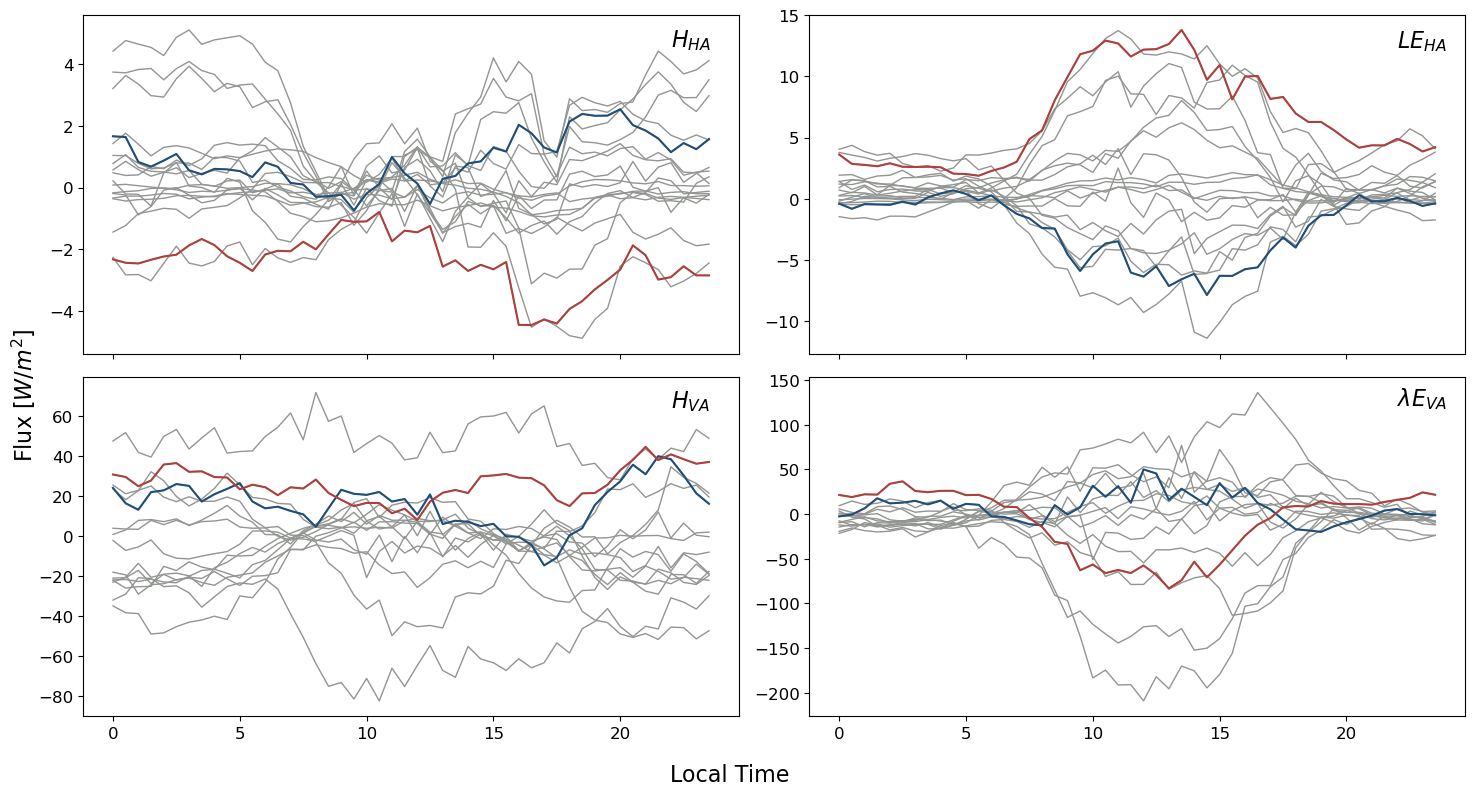

In [33]:
adv_day = adv_nanfilt.groupby(adv_nanfilt.index.time).mean()
fig, axs = plt.subplots(2, 2, figsize = (15, 8), sharex = True)
# tow = ['PFt']
for i in range(len(adv_comps)):
    comp = adv_comps[i]
    ax = axs[i//2, i%2]
    # ax = axs[i]
    for j in range(len(towlist)):
        tow = towlist[j]
        ax.plot(hh_index, adv_day[comp][tow], linewidth = 1, label = tow, c = colorlist[2])#j+6])
        # ax.plot(hh_index, adv_day[comp][tow], linewidth = 1, label = tow, c = 'k')#j+6])
    ax.plot(hh_index, adv_day[comp]['PFm'], c = colorlist[0])
    ax.plot(hh_index, adv_day[comp]['PFg'], c = colorlist[1])
    ax.annotate(comp_lab_list[i], (22, 0.9*adv_day[comp].max().max()), size = 16,  c= 'k')
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    
# plt.legend()
fig.supxlabel('Local Time', fontsize = 16)
fig.supylabel('Flux [$W/m^2$]', fontsize = 16)
plt.tight_layout()
    
plt.savefig('../../Thesis_materials/Presentation/adv_comp_diel_cycle_highlight.png')

In [34]:

# adv_colorlist = [colorlist[0], colorlist[1], colorlist[0], colorlist[1]]
# stylelist = ['-', '-', '--', '--']

# fig, axs = plt.subplots(6, 3, figsize = [10, 10], sharex=True, sharey=True)
# for i in range(len(towlist)):
#     tow = towlist[i]
#     ax = axs[i//3, i%3]             
#     for j in range(len(adv_comps)):
#         comp = adv_comps[j]
#         ax.plot(hh_index, adv_day[comp][tow].values, c = adv_colorlist[j], linestyle = stylelist[j])
        
#     # ax.plot(hh_index, E_budget.H_turb[tow].groupby(E_budget.H_turb.index.time).mean().values, c = colorlist[0], linestyle = 'dotted')
#     # ax.plot(hh_index, E_budget.LE_turb[tow].groupby(E_budget.LE_turb.index.time).mean().values, c = colorlist[1], linestyle = 'dotted')
#     ax.annotate(tc.dir_names.iloc[i], (0, 100))
    
# fig.supylabel('Flux [$W/m^2$]')
# fig.supxlabel('Local Time [hours]')
# plt.yticks([-200, -100, 0, 100])

# plt.savefig('../../Thesis_materials/diurnal_adv_cyc.png')

In [35]:
# avg_time = '7d'


# fig, axs = plt.subplots(2, 1, figsize = (8, 7), sharex = True)

# '''advection'''
# adv_resamp = adv_total.resample(avg_time).mean().mean(axis = 1)
# axs[0].plot(adv_resamp.index, adv_resamp, c = colorlist[0])
# x_dt, y = nanfilt(adv_resamp.index, adv_resamp)
# x = (x_dt - x_dt[0]).days
# regress = scipy.stats.linregress(x, y)
# y_bf = regress[0]*x + regress[1]
# axs[0].plot(x_dt, y_bf, c = colorlist[1])
# axs[0].annotate(str((regress[0]).round(3)) + 'x - ' + str(-regress[1].round(3)), (x_dt[-4], 10))

# print(adv_resamp.std(), y_bf[-1] - y_bf[0])

# axs[0].set_ylabel('Total Advection [$W/m^2$]')

# '''percent site-hours improved'''

# # cutoff_perc = 0.1

# # pos_impr = E_res_impr>cutoff_perc
# # neg_impr = E_res_impr<-cutoff_perc
# # no_impr = (E_res_impr<=cutoff_perc)&(E_res_impr>=-cutoff_perc)


# # pos_impr_count = pos_impr.resample(avg_time).sum().sum(axis = 1)
# # neg_impr_count = neg_impr.resample(avg_time).sum().sum(axis = 1)
# # no_impr_count = no_impr.resample(avg_time).sum().sum(axis = 1)
# # all_impr_count = pos_impr_count + neg_impr_count + no_impr_count

# # pos_impr_perc = pos_impr_count/all_impr_count*100
# # axs[1].plot(pos_impr_perc.index, pos_impr_perc, c = colorlist[0])

# # pos_impr_count = pos_impr.resample(avg_time).sum().sum(axis = 1)
# # pos_impr_perc = pos_impr_count/all_impr_count*100
# # x_dt, y = nanfilt(pos_impr_perc.index, pos_impr_perc)
# # x = (x_dt - x_dt[0]).days
# # regress = scipy.stats.linregress(x, y)
# # y_bf = regress[0]*x + regress[1]
# # axs[1].plot(x_dt, y_bf, c = colorlist[1])
# # axs[1].annotate(str(regress[0].round(3)) + 'x + ' + str(regress[1].round(3)), (x_dt[-24], 60))
# # axs[1].set_ylabel('Percent of Site-hours improved')

# '''Energy residual'''

# E_res_resamp = E_res_na.resample(avg_time).mean().mean(axis = 1)
# axs[1].plot(E_res_resamp.index, E_res_resamp, c = colorlist[0])

# x_dt, y = nanfilt(E_res_resamp.index, E_res_resamp)
# x = (x_dt - x_dt[0]).days
# regress = scipy.stats.linregress(x, y)
# y_bf = regress[0]*x + regress[1]
# axs[1].plot(x_dt, y_bf, c = colorlist[1])
# axs[1].annotate(str((regress[0]).round(3)) + 'x + ' + str(regress[1].round(3)), (x_dt[-4], 33))
# axs[1].set_ylabel('Energy Residaul [$W/m^2$]')

# '''Adv as percent of res'''

# # adv_perc = adv_total/E_res_na*100

# # adv_perc_resamp = adv_perc.resample(avg_time).mean().mean(axis = 1)
# # # adv_perc_resamp = adv_resamp/E_res_resamp
# # axs[2].plot(adv_perc_resamp.index, adv_perc_resamp, c = colorlist[0])
# # x_dt, y = nanfilt(adv_perc_resamp.index, adv_perc_resamp)
# # x = (x_dt - x_dt[0]).days
# # regress = scipy.stats.linregress(x, y)
# # y_bf = regress[0]*x + regress[1]
# # axs[2].plot(x_dt, y_bf, c = colorlist[1])
# # axs[2].annotate(str(regress[0].round(3)) + 'x - ' + str(-regress[1].round(3)), (x_dt[-20], 50))



# axs[0].set_ylabel('Total Advection [$W/m^2$]')


# axs[0].grid(True, which='both', linestyle='--', color='gray', alpha=0.7)
# axs[1].grid(True, which='both', linestyle='--', color='gray', alpha=0.7)
# # axs[2].grid(True, which='both', linestyle='--', color='gray', alpha=0.7)
# plt.xticks(rotation = 45);

# fig.supxlabel('Date')
# plt.tight_layout()

# plt.savefig('../../Thesis_materials/day_avg_timeseries.png')



In [36]:
# E_res_imp = (E_res_na.abs() - E_res_wa.abs())/E_res_na.abs()

# x = zeta[np.isfinite(zeta)]
# y = adv_total[np.isfinite(zeta)]


# #Find bin edges
# x_lin = x.stack(future_stack=True).reset_index()[0]
# bins_list = [x_lin.quantile(0)]
# for i in np.arange(.1, 1, .1):
#     bins_list.append(x_lin.quantile(i))
    
# bins_list.append(x_lin.quantile(1))

# bins_array = np.array(bins_list)

# # Create bins
# bins = pd.cut(x.stack(future_stack=True).reset_index()[0], bins=bins_array, right=False)

# y_lin = y.stack(future_stack=True).reset_index()[0] #1D y
# y_grpd = y_lin.groupby(bins, observed = False).apply(list).reset_index(name = '0')

# boxplot_data = []
# for idx, row in y_grpd.iterrows():
#     for value in row['0']:
#         boxplot_data.append({'Bin': row[0], 'Value': value})
        
# # Convert to DataFrame
# boxplot_df = pd.DataFrame(boxplot_data)
        
# fig, ax = plt.subplots(1, figsize=(10, 5))
# sns.boxplot(ax = ax, x='Bin', y='Value', data=boxplot_df, color = colorlist[0])

# ax.set_xlabel('$z/L$', fontsize = 14)
# ax.set_ylabel('Total Advective Flux [$W/m^2$]', fontsize = 14)
# ax.set_ylim(-400, 425)
# ax.tick_params(axis='x', labelrotation=45);

# #u* boxplots


# x = hrz_wind['Ustar']
# y = adv_total


# #Find bin edges
# x_lin = x.stack(future_stack=True).reset_index()[0]
# bins_list = [x_lin.quantile(0)]
# for i in np.arange(.1, 1, .1):
#     bins_list.append(x_lin.quantile(i))
    
# bins_list.append(x_lin.quantile(1))

# bins_array = np.array(bins_list)

# # Create bins 
# bins = pd.cut(x.stack(future_stack=True).reset_index()[0], bins=bins_array, right=False)


# y_lin = y.stack(future_stack=True).reset_index()[0] #1D y
# y_grpd = y_lin.groupby(bins, observed = False).apply(list).reset_index(name = '0')


# # boxplot_data = []
# # for idx, row in y_grpd.iterrows():
# #     for value in row['0']:
# #         boxplot_data.append({'Bin': row[0], 'Value': value})
        
# # # Convert to DataFrame
# # boxplot_df = pd.DataFrame(boxplot_data)

# # sns.boxplot(ax = axs[1], x='Bin', y='Value', data=boxplot_df, color = colorlist[0])

# # axs[1].set_xlabel('$u_*$ [$m/s$]')
# # axs[1].set_ylabel('')
# # axs[1].set_ylim(-400, 425)
# # axs[1].tick_params(axis='x', labelrotation=45);


# # fig.supylabel('Total Advective Flux [$W/m^2$]')
# # fig.supxlabel('$z/L$', fontsize = 14)
# plt.tight_layout()
# plt.savefig('../../Thesis_materials/Presentation/atm_var_boxplot.png')




In [37]:
#Calculate median values of different groups in plot above
np.nanmedian(y_grpd.loc[4].values[1])

NameError: name 'y_grpd' is not defined

## Case Study

In [ ]:
# cutstart = dt.datetime(2019, 8, 29)
# cutend = dt.datetime(2019, 9, 1, 15)

# cutstart_1 = dt.datetime(2019, 8, 29, 17)
# cutend_1 = dt.datetime(2019, 8, 30, 17)

# cutstart_2 = dt.datetime(2019, 8, 31, 8)
# cutend_2 = dt.datetime(2019, 9, 1, 8)

# tow = 'PFg'

# fig, ax = plt.subplots(1, 1, figsize = [6, 6])

# ax.plot(E_res_na[tow][cutstart:cutend], c = 'k')
# ax.plot(adv_total[tow][cutstart:cutend], c = colorlist[2])

# ax.axvspan(cutstart_1, cutend_1, color=colorlist[5], alpha=0.5)
# ax.axvspan(cutstart_2, cutend_2, color=colorlist[6], alpha=0.5)


# ax.tick_params(axis='x', labelrotation=45);

# ax.set_xlabel('Date and Hour')
# ax.set_ylabel('Energy Flux [$W/m^2$]')

# plt.savefig('../../Thesis_materials/Case_study_timeseries.png')


                 

In [ ]:
#Ax 2
fig, ax = plt.subplots(1, 1, figsize = [6, 6])
ax.scatter(E_res_na[tow][cutstart_1:cutend_1], adv_total[tow][cutstart_1:cutend_1], c = colorlist[3])
ax.scatter(E_res_na[tow][cutstart_2:cutend_2], adv_total[tow][cutstart_2:cutend_2], c = colorlist[4])

regress_1 = scipy.stats.linregress(nanfilt(E_res_na[tow][cutstart_1:cutend_1], adv_total[tow][cutstart_1:cutend_1]))
regress_2 = scipy.stats.linregress(nanfilt(E_res_na[tow][cutstart_2:cutend_2], adv_total[tow][cutstart_2:cutend_2]))

x = np.arange(-100, 200, 2)
y_1 = regress_1[0]*x + regress_1[1]
y_2 = regress_2[0]*x + regress_2[1]

ax.plot(x, y_1, c = colorlist[0], linestyle = '--')
ax.plot(x, y_2, c = colorlist[1], linestyle = '--')
ax.set_xlabel('Energy Imbalance [$W/m^2$]')
ax.set_ylabel('Advective Flux [$W/m^2$]')


plt.savefig('../../Thesis_materials/Case_study_EBadv_scatter.png')

In [ ]:
regress_1[0], regress_1[2]**2
regress_2[0], regress_2[2]**2

In [ ]:
# cut_towlist =['PFg', 'PFe', 'PFh', 'PFj', 'PFl', 'PFm']#, 'PFp', 'PFt'] 
# cut_towlist_dir = tc.loc[cut_towlist]['dir_names']
# colorlist_sub = ['#1F4E79','#AD403D','#2E75B6','#CB6D6B']

# Imb_df = pd.DataFrame(index = cut_towlist, columns = ['NA_all', 'WA_all', 'NA_cut', 'WA_cut'])

# for tow in cut_towlist:
#     Imb_df.loc[tow, 'NA_all'] = E_res_na[tow].mean()
#     Imb_df.loc[tow, 'WA_all'] = E_res_wa[tow].mean()
#     Imb_df.loc[tow, 'NA_cut'] = E_res_na[cutstart_1:cutend_1][tow].mean()
#     Imb_df.loc[tow, 'WA_cut'] = E_res_wa[cutstart_1:cutend_1][tow].mean()
#     # Imb_df.loc[tow, 'NA_cut'] = E_res_na[cutstart_2:cutend_2][tow].mean()
#     # Imb_df.loc[tow, 'WA_cut'] = E_res_wa[cutstart_2:cutend_2][tow].mean()
 
# #Set the figure size
# fig, ax = plt.subplots(figsize=(10, 6))

# # Number of towers (rows) and number of columns
# towers = Imb_df.index
# columns = Imb_df.columns
# n_towers = len(towers)
# n_columns = len(columns)

# # Define the width of each bar and create an array for bar positions
# bar_width = 0.2
# indices = np.arange(n_towers)
# labellist = ['$Imb_{NA}$ all', '$Imb_A$ all', '$Imb_{NA}$ period 1', '$Imb_A$ period 1']

# # Plot each column as a separate bar
# for i, col in enumerate(columns):
#     ax.bar(indices + i * bar_width, Imb_df[col], width=bar_width, label=labellist[i], color = colorlist_sub[i])

# # Set labels, title, and x-ticks
# ax.set_xlabel('Tower')
# ax.set_ylabel('Energy Imbalance [$W/m^2$]')
# ax.set_xticks(indices + bar_width * (n_columns - 1) / 2)  # Center x-ticks
# ax.set_xticklabels(cut_towlist_dir)

# # Add a legend
# ax.legend()

# # Show plot
# plt.tight_layout()

# plt.axhline(0, color = 'gray', linestyle = '--', alpha = 0.5)

# plt.savefig('../../Thesis_materials/Case_study_Res_barchart.png')


In [ ]:
# tow = 'PFg'

# fig, ax = plt.subplots(1, figsize = (5, 5))

# lim = 10 #Lim for Br used in regression
# plt_lim = 4 #Lim for plotting

# BR_turb_cut = BR_turb[cutstart_1:cutend_1][tow]
# BR_adv_cut = BR_adv[cutstart_1:cutend_1][tow]
# x, y = nanfilt(BR_turb_cut.where((BR_turb_cut<lim) & (BR_turb_cut>-lim)).to_numpy().flatten(), BR_adv_cut.where((BR_adv_cut<lim) &(BR_adv_cut >-lim)).to_numpy().flatten())
# # x, y = nanfilt(BR_turb_cut.to_numpy().flatten(), BR_adv_cut.to_numpy().flatten())


# ax.scatter(x, y, c = colorlist[0], alpha = 0.5)
# ax.set_xlim(-plt_lim, plt_lim)
# ax.set_ylim(-plt_lim, plt_lim)


# regress = scipy.stats.linregress(x, y)
# plt_lim = 10

# x_11 = np.arange(0.5-plt_lim, 3*plt_lim-1.5, 2*plt_lim-1)
# ax.plot(x_11, x_11, c = 'k')
# ax.plot(x_11, regress[0]*x_11 + regress[1], c = colorlist[1])
# ax.set_xlabel('Bowen Ratio of turbulent fluxes')
# ax.set_ylabel('Bowen Ratio of advective fluxes')

# ax.annotate('$R^2$ = ' + str((regress[2]**2).round(3)), (-3.5, 3))

# print('slope:', regress[0])
# plt.savefig('../../Thesis_materials/NE1P1_BR_scatter.png')


In [ ]:
# '''Hrz v vert advective fluxes'''

# x_11 = np.arange(-25, 50, 70)

# fig, ax = plt.subplots(1, 2, figsize = [8, 6], sharex = True, sharey = True)

# adv_cut = adv_nanfilt[cutstart_1:cutend_1]

# #Horizontal Fluxes
# x, y = nanfilt(adv_cut.H_hrz[tow].to_numpy().flatten(), adv_cut.H_vert[tow].to_numpy().flatten())
# regress = scipy.stats.linregress(x, y)
# ax[0].scatter(x, y, c=colorlist[0], alpha = 0.5);
# ax[0].plot(x_11, regress[0]*x_11 + regress[1], c = colorlist[1])
# ax[0].annotate('H', (35, 300), size = 15, c = colorlist[1])
# print('H R2: ', regress[2]**2)
# ax[0].annotate('$R^2$ = ' + str((regress[2]**2).round(3)), (-20, 300))

# #Vertical Fluxes
# x, y = nanfilt(adv_cut.LE_hrz[tow].to_numpy().flatten(), adv_cut.LE_vert[tow].to_numpy().flatten())
# regress = scipy.stats.linregress(x, y)
# ax[1].scatter(x, y, c=colorlist[0], alpha = 0.5);
# ax[1].plot(x_11, regress[0]*x_11 + regress[1], c = colorlist[1])
# ax[1].annotate('LE', (35, 300), size = 15, c = colorlist[1])
# ax[1].annotate('$R^2$ = ' + str((regress[2]**2).round(4)), (-20, 300))

# plt.xlim(-30, 50)
# plt.ylim(-250, 350)


# fig.supxlabel('Horizontal Flux [$W/m^2$]')
# fig.supylabel('Vertical Flux [$W/m^2$]')

# plt.savefig('../../Thesis_materials/hrz_v_vert_adv_NE1P1.png')
# print('LE R2: ', regress[2]**2)






## Sensitivity Analysis

In [ ]:

hrz_tot_A = H_hrz['A'].where(nancount.max(axis = 1)<=towsmin) + LE_hrz['A'].where(nancount.max(axis = 1)<=towsmin)
vert_tot_son = vert_ad_son['H'].where(nancount.max(axis = 1)<=towsmin) + vert_ad_son['H'].where(nancount.max(axis = 1)<=towsmin)
vert_tot_cont = vert_ad_cont['H'].where(nancount.max(axis = 1)<=towsmin) + vert_ad_cont['H'].where(nancount.max(axis = 1)<=towsmin)

dist_list = [10, 100, 500, 5000]

fig, axs = plt.subplots(1, 4, figsize = (15, 4))
# RMSD = pd.DataFrame(index = cases.index[1:], columns = ['RMSD'])

for i in range(4):
    case = ['D', 'E', 'F', 'G'][i]
    ax = axs[i]
    hrz_tot = H_hrz[case].where(nancount.max(axis = 1)<=towsmin) + LE_hrz[case].where(nancount.max(axis = 1)<=towsmin)
    ax.scatter(hrz_tot_A + vert_tot_son, hrz_tot + vert_tot_son, marker = '.', c = colorlist[0], alpha = 0.2)
    # RMSD_case  = (((hrz_tot_A - hrz_tot)**2).mean().mean())**(1/2)
    # RMSD.loc[case, 'RMSD'] = RMSD_case 
    
    # if case == 'I' or case == 'J' or case == 'D':
    #     ax.annotate(case, (-140, hrz_tot.max().max()*0.9), fontsize = 10, c = colorlist[1])
    #     ax.annotate('RMSD: ' + str(round(RMSD_case, 2)), (40, hrz_tot.min().min()*0.9), fontsize = 10)
    # else:
    ax.annotate('$\Delta x$ = ' + str(dist_list[i]) + ' m', (-1900, 1500), fontsize = 12, c = colorlist[1])
    #     ax.annotate('RMSD: ' + str(round(RMSD_case, 2)), (40, -133), fontsize = 10)
    x11 = np.arange(-2000, 1800, 50)
    ax.plot(x11, x11, c = 'k', linestyle = '--', zorder = 1)
    ax.set_xlim(-2200, 2000)
    ax.set_ylim(-2200, 2000)
    
    
# axs[3, 2].scatter(vert_tot_son, vert_tot_cont, marker = '.', c = colorlist[0], alpha = 0.2)
# RMSD_case  = (((vert_tot_son - vert_tot_cont)**2).mean().mean())**(1/2)
# axs[3, 2].annotate('RMSD: ' + str(round(RMSD_case, 1)), (300, vert_tot_cont.min().min()*0.9), fontsize = 10)
# axs[3, 2].annotate('Vertical', (-2100, vert_tot_cont.max().max()*0.9), fontsize = 10, c = colorlist[1])
# x11 = np.arange(-2100, 2100, 50)
# axs[3, 2].plot(x11, x11, c = 'k', linestyle = '--', zorder = 1)

fig.supxlabel('Primary Case Flux [$W/m^2$]', fontsize = 16)
fig.supylabel('Secondary Case Flux [$W/m^2$]', fontsize = 16)

plt.tight_layout()
plt.savefig('../../Thesis_materials/Presentation/sensitivity_anals_dist_with_vert.png')

In [ ]:
plt.figure(figsize = (10, 10)) 
plt.scatter(vert_tot_son, vert_tot_cont, marker = '.', c = colorlist[0], alpha = 0.2)


x11 = np.arange(-2100, 2100, 50)
plt.plot(x11, x11, c = 'k', linestyle = '--', zorder = 1)

plt.xlabel('VA from Sonic [$W/m^2$]', fontsize = 16)
plt.ylabel('VA from Continuity [$W/m^2$]', fontsize = 16)
plt.xlim(-1500, 1500)
plt.ylim(-2500, 2000)

plt.tight_layout()
plt.savefig('../../Thesis_materials/Presentation/sensitivity_anals_scatter.png')

In [ ]:
vert_tot_cont.stack().std(), vert_tot_son.stack().std()

In [ ]:
cases

In [ ]:

caselist = cases.index
diurnal_all_case_son = pd.DataFrame()
diurnal_all_case_cont = pd.DataFrame()
hrz_all_case = H_hrz.groupby(H_hrz.index.time).mean() + LE_hrz.groupby(H_hrz.index.time).mean()

vert_son_day = vert_ad_son.groupby(vert_ad_son.index.time).mean()
vert_cont_day = vert_ad_cont.groupby(vert_ad_cont.index.time).mean()

for case in cases.index:
    diurnal_all_case_son[case] = (hrz_all_case[case] + vert_son_day['H'] + vert_son_day['LE']).mean(axis = 1)
    diurnal_all_case_cont[case] = (hrz_all_case[case] + vert_cont_day['H'] + vert_cont_day['LE']).mean(axis = 1)

plt.plot(hh_index, diurnal_all_case_son, c = colorlist[3], linewidth = 1, alpha = 1);
plt.plot(hh_index, diurnal_all_case_cont, c = colorlist[4], linewidth = 1, alpha = 1);
# plt.plot(hh_index, E_res_na.groupby(E_res_na.index.time).mean().mean(axis = 1), c = 'k');

plt.xlabel('Local Time [hr]')
plt.ylabel('Energy Flux [$W/m^2$]')
# plt.savefig('../../Thesis_materials/all_cases_diel.png')

In [ ]:
pos_impr_perc

In [ ]:
hrz_tot_A.mean()

In [ ]:
tow_dists = pd.DataFrame(index = towlist, columns = towlist)
for tow in towlist:
    tow_dists[tow] = ((tc.loc[tow].x - tc.x)**2 + (tc.loc[tow].y - tc.y)**2)**(1/2)
tow_dist_mins = tow_dists.where(tow_dists>0).min()/1000

pos_impr_count = pos_impr.sum()
no_impr_count = no_impr.sum()
neg_impr_count = neg_impr.sum()

all_impr_count = pos_impr_count + neg_impr_count + no_impr_count

pos_impr_perc = pos_impr_count/all_impr_count*100

x, y = nanfilt(tow_dist_mins, pos_impr_perc)
x, y = nanfilt(tow_dist_mins, hrz_tot_A.mean())

# plt.scatter(tow_dist_mins, (E_res_na.mean().abs() - E_res_wa.mean().abs())/E_res_na.mean().abs())
plt.scatter(x, y, c = colorlist[0])


regress = scipy.stats.linregress(x, y)
x_11 = np.arange(x.min()-0.2, x.max() +0.2, .1)
plt.plot(x_11, regress[0]*x_11 + regress[1], c = colorlist[1])


plt.annotate(str((regress[0]).round(3)) + 'x + ' + str(regress[1].round(3)), (2.12, 40))
plt.xlabel('Distance to nearest tower [$km$]')
# plt.ylabel('Percent of site-hours improved')
plt.ylabel('Total Horizontal Advection [$W/m^2$]')
print('R2', regress[2]**2)
plt.savefig('../../Thesis_materials/tow_distv_adv.png')

In [ ]:
plt.figure(figsize = (12, 6))

plt.plot(E_budget.Rnet.groupby(E_budget.index.hour).mean().mean(axis = 1), c = '#FFC000', label = '$R_n$')
plt.plot(E_budget.G.groupby(E_budget.index.hour).mean().mean(axis = 1), c = '#7F6000', label = '$G$')
plt.plot(E_budget.H_turb.groupby(E_budget.index.hour).mean().mean(axis = 1), c= '#C55A11', label = '$H$')
plt.plot(E_budget.LE_turb.groupby(E_budget.index.hour).mean().mean(axis = 1), c = '#2E75B6', label = '$\lambda E$')
plt.plot(E_res_na.groupby(E_res_na.index.hour).mean().mean(axis = 1), 'k', label = '$Imb$', linewidth = 3)


# plt.plot(E_budget.G.groupby(E_budget.index.hour).mean().mean(axis = 1), c = '#7F6000', label = '$G$')
# plt.plot(E_budget.H_turb.groupby(E_budget.index.hour).mean().mean(axis = 1), c= '#C55A11', label = '$H$')
# plt.plot(E_budget.LE_turb.groupby(E_budget.index.hour).mean().mean(axis = 1), c = '#2E75B6', label = '$\lambda E$')
# plt.plot([], [], 'k', label = '$Imb$', linewidth = 3)# Just here to have Imb in legend even when the line isn't

plt.grid(True, which='both', linestyle='--', color='gray', alpha=0.7)

plt.xlabel('Local Time', fontsize = 16)
plt.ylabel('Energy Flux [$W/m^2$]', fontsize = 16)
# plt.legend(fontsize = 12)
plt.xticks(fontsize = 12);
plt.yticks(fontsize = 12);

# plt.savefig('../../Thesis_materials/Presentation/E_comps_dcyc_RnLE.png') #No imbalance
# plt.savefig('../../Thesis_materials/Presentation/E_comps_dcyc_no_imb.png') #No imbalance
plt.savefig('../../Thesis_materials/Presentation/E_comps_dcyc_imb.png') #With imbalance

# E_res_na_all = E_budget.Rnet - E_budget.G - E_budget.H_turb - E_budget.LE_turb - E_budget.SH - E_budget.SLE  + E_budget.SG

## Wind profile example

In [ ]:
tow='PFn'
wind_prof_ex = wind_prof(tow = tow, stab_meth = None, WS_use = hrz_wind['WS_top'][tow], MO_tow = MO[tow], dtindex = dtindex)

In [ ]:
tc

In [ ]:
plotdate = dt.datetime(2019, 7, 20, 18)
plt.plot(wind_prof_ex.loc[plotdate], wind_prof_ex.columns, c = colorlist[0])

# #Change colors of different section
# plt.plot(wind_prof_ex.loc[plotdate].where(wind_prof_ex.columns < tc.loc[tow]['veg_h']), 
#          wind_prof_ex.columns.where(wind_prof_ex.columns < tc.loc[tow]['veg_h']), c = colorlist[1])

# plt.plot(wind_prof_ex.loc[plotdate].where(wind_prof_ex.columns < tc.loc[tow]['veg_h']*0.1), 
#          wind_prof_ex.columns.where(wind_prof_ex.columns < tc.loc[tow]['veg_h']*0.1), c = colorlist[0])

#Shaded bands
plt.axhspan(tc.loc[tow]['veg_h'], tc.loc[tow]['z1'], color=colorlist[1], alpha=0.3)
# plt.axhspan(tc.loc[tow]['veg_h']*0.1, tc.loc[tow]['veg_h'], color=colorlist[1], alpha=0.3)
# plt.axhspan(0, tc.loc[tow]['veg_h']*0.1, color=colorlist[1], alpha=0.3)



plt.xlim(0, 1.5)
plt.ylim(0, 35)
plt.xlabel('Wind Speed [$m/s$]', fontsize = 12)
plt.ylabel('Height [$m$]', fontsize = 12)
plt.savefig('../../Thesis_materials/Presentation/wind_prof_shade1.png')